In [ ]:
# Install all packages
# Restart runtime after installation

#!wget https://github.com/PranjalSahu/ITKThinShellDemons/raw/pranjal_setup/itk_thinshelldemons-0.1.1-cp38-cp38m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
#!pip install itk_thinshelldemons-0.1.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
#!pip install itk_thinshelldemons-0.1.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install itk_thinshelldemons-0.1.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install itk==5.3rc4
!pip install vtk
!pip install itkwidgets

In [1]:
# Import all packages

import numpy as np
#import itkConfig
#itkConfig.LazyLoading = False
import itk
import vtk
import itkwidgets
import math
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
import time
import copy

from vtk.util import numpy_support
from vtk.util.numpy_support import numpy_to_vtk
# To enable itkwidgets window
#from google.colab import output
#output.enable_custom_widget_manager()

In [242]:
# Helper Functions

def subsample_points(inputmesh, mesh_sub_sample_points, seed):
    import vtk
    from vtk.util import numpy_support

    sample = vtk.vtkPolyDataPointSampler()
    sample.SetInputData(inputmesh)
    sample.SetGenerateEdgePoints(0)
    sample.SetGenerateInteriorPoints(0)
    sample.SetPointGenerationModeToRegular()
    sample.SetDistance(0.5)
    sample.Update()

    sampled_points = sample.GetOutput()

    points = sampled_points.GetPoints()
    pointdata = points.GetData()

    as_numpy = numpy_support.vtk_to_numpy(pointdata)
    
    np.random.seed(seed)
    random_indices = np.random.choice(as_numpy.shape[0],
                                      size=mesh_sub_sample_points,
                                      replace=False)
    as_numpy_sampled = as_numpy[random_indices, :]

    return as_numpy_sampled

def subsample_points_poisson(inputMesh):
    import vtk
    from vtk.util import numpy_support
    f = vtk.vtkPoissonDiskSampler()
    f.SetInputData(inputMesh)
    f.SetRadius(4.5)
    f.Update()
    sampled_points = f.GetOutput()
    points = sampled_points.GetPoints()
    pointdata = points.GetData()
    as_numpy = numpy_support.vtk_to_numpy(pointdata)
    return as_numpy

def readvtk(filename):
    a = vtk.vtkPolyDataReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

def readply(filename):
    a = vtk.vtkPLYReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

def getnormals(inputmesh):
    normals = vtk.vtkTriangleMeshPointNormals()
    normals.SetInputData(inputmesh)
    normals.Update()
    return normals.GetOutput()


In [ ]:
# File paths

#MOVING_MESH_FILE = '/data/Apedata/CorrectData/data/Pan/meshes/USNM220065-Cranium_merged_1.ply'
#FIXED_MESH_FILE  = '/data/Apedata/CorrectData/data/Gorilla/meshes/USNM252575-Cranium.ply'

# ransac registered
MOVING_MESH_FILE = '/home/pranjal.sahu/Documents/SampleApeData1/USNM174701-Cranium_merged_1.ply'
# original mesh
#MOVING_MESH_FILE = '/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium.ply'

FIXED_MESH_FILE  = '/home/pranjal.sahu/Documents/SampleApeData1/USNM174722-Cranium.ply'

paths = [FIXED_MESH_FILE, MOVING_MESH_FILE]

In [3]:
# Fetch the files

FIXED_MESH_FILE  = r'data/129S1_SVIMJ_.ply'
MOVING_MESH_FILE = r'data/129X1_SVJ_.ply'
paths = [FIXED_MESH_FILE, MOVING_MESH_FILE]

import os
import importlib
from urllib.request import urlretrieve

# Download meshes
os.makedirs('data',exist_ok=True)
if not os.path.exists(FIXED_MESH_FILE):
    url = 'https://github.com/SlicerMorph/Mouse_Models/raw/main/Models/129S1_SVIMJ_.ply'
    urlretrieve(url, FIXED_MESH_FILE)
if not os.path.exists(MOVING_MESH_FILE):
    url = 'https://github.com/SlicerMorph/Mouse_Models/raw/main/Models/129X1_SVJ_.ply'
    urlretrieve(url, MOVING_MESH_FILE)

In [3]:
# Clean the meshes and Triangulate them as TSD only works with Triangle Meshes

vtk_meshes = list()

for path in paths:
    reader = vtk.vtkPLYReader()
    reader.SetFileName(path)
    reader.Update()
        
    cleaner = vtk.vtkCleanPolyData()
    cleaner.SetInputData(reader.GetOutput())
    cleaner.ConvertLinesToPointsOn()
    cleaner.ConvertPolysToLinesOff()
    cleaner.SetTolerance(0.0)
    cleaner.Update()
    vtk_mesh = cleaner.GetOutput()

    triangle_filter = vtk.vtkTriangleFilter()
    triangle_filter.SetInputData(vtk_mesh)
    triangle_filter.SetPassLines(False)
    triangle_filter.SetPassVerts(False)
    triangle_filter.Update()
    vtk_mesh = triangle_filter.GetOutput()
    
    vtk_meshes.append(vtk_mesh)
    
# Write back out to a filetype supported by ITK
vtk_paths = [path.strip('.ply') + '.vtk' for path in paths]
for idx, mesh in enumerate(vtk_meshes):
    writer = vtk.vtkPolyDataWriter()
    writer.SetInputData(mesh)
    writer.SetFileVersion(42)
    writer.SetFileTypeToBinary()
    writer.SetFileName(vtk_paths[idx])
    writer.Update()
    
itk_meshes = [itk.meshread(path, pixel_type=itk.D) for path in vtk_paths]

In [4]:
# Convert meshes to images for performing moment based initialization

itk_transformed_meshes= []
# itk_meshes = []
# itk_meshes.append(itk.meshread('itk_meshes_0.vtk'))
# itk_meshes.append(itk.meshread('itk_meshes_1.vtk'))

itk_images = []
for mesh in itk_meshes:
    # Get all the points to positive values
    temp = itk.array_from_vector_container(mesh.GetPoints())
    m    = np.min(temp, 0)
    temp = temp - m
    mesh.SetPoints(itk.vector_container_from_array(temp.flatten())) 
    
    itk_transformed_meshes.append(mesh)
    itk_image = itk.triangle_mesh_to_binary_image_filter(mesh,
                                                      origin=[0, 0, 0],
                                                      spacing=[1, 1, 1],
                                                      size=[250, 250, 250])
    itk_images.append(itk_image)
                                                         

itk_transforms = list()

for image in itk_images:
    calculator = itk.ImageMomentsCalculator[type(image)].New()
    calculator.SetImage(image)
    calculator.Compute()
    itk_transforms.append(calculator.GetPhysicalAxesToPrincipalAxesTransform())

In [5]:
# Write the Moment based initialized meshes as vtk file

itk_transformed_meshes = [
    itk.transform_mesh_filter(mesh, transform=itk_transforms[idx])
    for idx, mesh in enumerate(itk_meshes)
]

fixedMesh  = itk_meshes[0]#itk_transformed_meshes[0]
movingMesh = itk_meshes[1]#itk_transformed_meshes[1]


w1 = itk.MeshFileWriter[type(movingMesh)].New()
w1.SetFileName('movingMesh.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(movingMesh)
w1.Update()

w1 = itk.MeshFileWriter[type(movingMesh)].New()
w1.SetFileName('fixedMesh.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(fixedMesh)
w1.Update()

#itk.meshwrite(movingMesh, 'movingMesh.vtk')
#itk.meshwrite(fixedMesh, 'fixedMesh.vtk')

In [4]:
movingMeshPath = 'movingMesh.vtk'
fixedMeshPath = 'fixedMesh.vtk'

movingMesh = readvtk(movingMeshPath)
fixedMesh  = readvtk(fixedMeshPath)

movingMeshAllPoints = numpy_support.vtk_to_numpy(
    movingMesh.GetPoints().GetData())

movingMeshPoints = subsample_points_poisson(movingMesh)
fixedMeshPoints  = subsample_points_poisson(fixedMesh)

print(fixedMeshPoints.shape)

def get_bounding_box_data(inputMeshPoints):
    ElementIdentifierType = itk.UL
    CoordType = itk.F
    Dimension = 3

    VecContType = itk.VectorContainer[
        ElementIdentifierType, itk.Point[CoordType, Dimension]
    ]

    ps = itk.PointSet.D3.New()
    ps.SetPoints(itk.vector_container_from_array(inputMeshPoints.flatten()))

    bounding_box = itk.BoundingBox[ElementIdentifierType, Dimension, CoordType, VecContType].New()
    bounding_box.SetPoints(ps.GetPoints())
    bounding_box.ComputeBoundingBox()

    minBounds = np.array(bounding_box.GetMinimum())
    maxBounds = np.array(bounding_box.GetMaximum())
    
    return maxBounds - minBounds, bounding_box.GetCenter()

def scale_mesh(input_mesh, scale_factor):
    mesh_points = itk.array_from_vector_container(input_mesh.GetPoints())
    mesh_points =  mesh_points * scale_factor
    input_mesh.SetPoints(itk.vector_container_from_array(mesh_points.flatten()))
    return input_mesh
    
def perform_scaling_and_centering(movingPoints, fixedPoints, movingMesh, fixedMesh):
    sourceSize = np.linalg.norm(np.max(movingPoints, 0) - np.min(movingPoints, 0))
    targetSize = np.linalg.norm(np.max(fixedPoints, 0) - np.min(fixedPoints, 0))

    scaling = (targetSize)/sourceSize

    scaledMovingPoints = movingPoints * scaling
    scaledMovingMesh   = scale_mesh(movingMesh, scaling)
    
    return scaledMovingPoints, scaledMovingMesh

movingMesh = itk.meshread(movingMeshPath, itk.D)
fixedMesh  = itk.meshread(fixedMeshPath, itk.D)

movingMeshPoints, scaledMovingMesh = perform_scaling_and_centering(movingMeshPoints, fixedMeshPoints, movingMesh, fixedMesh)

print(movingMeshPoints.shape, scaledMovingMesh.GetNumberOfPoints())

w1 = itk.MeshFileWriter[type(scaledMovingMesh)].New()
w1.SetFileName('movingMeshScaled.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(scaledMovingMesh)
w1.Update()

(8002, 3)
(3754, 3) 2209640


In [47]:
# movingMeshPath = 'movingMeshScaled.vtk'
# fixedMeshPath = 'fixedMesh.vtk'

movingMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Source Pointcloud (rigidly registered)_1.vtk'
fixedMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Target Pointcloud_1.vtk'

movingMesh = readvtk(movingMeshPath)
fixedMesh  = readvtk(fixedMeshPath)

itkwidgets.view(geometries=[fixedMesh, movingMesh])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [ ]:
# For performing RANSAC in parallel

from vtk.util import numpy_support
from vtk.util.numpy_support import numpy_to_vtk

def get_euclidean_distance():
    mesh_fixed = itk.Mesh[itk.D, 3].New()
    mesh_moving = itk.Mesh[itk.D, 3].New()

    mesh_fixed.SetPoints(itk.vector_container_from_array(
        fixedPoints.flatten()))
    mesh_moving.SetPoints(
        itk.vector_container_from_array(movingPoints.flatten()))
    
    MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
    metric = MetricType.New()
    metric.SetMovingPointSet(mesh_moving)
    metric.SetFixedPointSet(mesh_fixed)
    metric.Initialize()
    
def final_iteration(fixedPoints, movingPoints, transform_type):
    mesh_fixed = itk.Mesh[itk.D, 3].New()
    mesh_moving = itk.Mesh[itk.D, 3].New()

    mesh_fixed.SetPoints(itk.vector_container_from_array(
        fixedPoints.flatten()))
    mesh_moving.SetPoints(
        itk.vector_container_from_array(movingPoints.flatten()))

    if transform_type == 0:
        TransformType = itk.Euler3DTransform[itk.D]
    elif transform_type == 1:
        TransformType = itk.ScaleVersor3DTransform[itk.D]
    elif transform_type == 2:
        TransformType = itk.Similarity3DTransform[itk.D]
    else:
        TransformType = itk.AffineTransform[itk.D, 3]

    transform = TransformType.New()
    transform.SetIdentity()

    MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
    metric = MetricType.New()
    metric.SetMovingPointSet(mesh_fixed)
    metric.SetFixedPointSet(mesh_moving)
    metric.SetMovingTransform(transform)
    metric.Initialize()

    print('Initial Value ', metric.GetValue())    
    number_of_epochs = 50000
    optimizer = itk.GradientDescentOptimizerv4Template[itk.D].New()
    optimizer.SetNumberOfIterations(number_of_epochs)
    optimizer.SetLearningRate(0.0001)
    optimizer.SetMinimumConvergenceValue(0.0)
    optimizer.SetConvergenceWindowSize(number_of_epochs)
    optimizer.SetMetric(metric)

    def print_iteration():
        print(f"It: {optimizer.GetCurrentIteration()}"
              f" metric value: {optimizer.GetCurrentMetricValue():.6f} ")

    optimizer.AddObserver(itk.IterationEvent(), print_iteration)
    optimizer.StartOptimization()

    print('Final Value ', metric.GetValue())
    
    current_transform = metric.GetTransform()
    itk_transformed_mesh = itk.transform_mesh_filter(
        mesh_moving, transform=current_transform)

    return itk.array_from_vector_container(itk_transformed_mesh.GetPoints())

def ransac_icp_parallel(fixedMeshPoints, movingMeshPoints, movingMeshAllPoints,
                        number_of_iterations, mesh_sub_sample_points,
                        number_of_ransac_points, transform_type,
                        convergance_value):
    import numpy as np
    np.random.seed(0)

    all_points1 = fixedMeshPoints
    all_points2 = movingMeshPoints

    def process(i, mesh_sub_sample_points, number_of_ransac_points,
                return_result):
        # Create Mesh inside the method to tackle the problem of serialization
        
        import itk
        
        mesh_fixed = itk.Mesh[itk.D, 3].New()
        mesh_moving = itk.Mesh[itk.D, 3].New()

        mesh_fixed.SetPoints(
            itk.vector_container_from_array(all_points1.flatten()))
        mesh_moving.SetPoints(
            itk.vector_container_from_array(all_points2.flatten()))

        ps1 = itk.Mesh[itk.D, 3].New()
        ps2 = itk.Mesh[itk.D, 3].New()
        
        # Create small point sets
        np.random.seed(i)
        random_indices = np.random.choice(all_points1.shape[0],
                                          size=number_of_ransac_points)
        p1_a = all_points1[random_indices, :]

        random_indices = np.random.choice(all_points2.shape[0],
                                          size=number_of_ransac_points)
        p2_a = all_points2[random_indices, :]

        ps1.SetPoints(itk.vector_container_from_array(p1_a.flatten()))
        ps2.SetPoints(itk.vector_container_from_array(p2_a.flatten()))

        if transform_type == 0:
            # works best
            TransformType = itk.Euler3DTransform[itk.D]
        elif transform_type == 1:
            # does not work well
            TransformType = itk.ScaleVersor3DTransform[itk.D]
        elif transform_type == 2:
            # works ok
            TransformType = itk.Similarity3DTransform[itk.D]
        else:
            TransformType = itk.AffineTransform[itk.D, 3]

        transform = TransformType.New()
        transform.SetIdentity()
        
        MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
        metric = MetricType.New()
        metric.SetMovingPointSet(ps2)
        metric.SetFixedPointSet(ps1)
        metric.SetMovingTransform(transform)
        metric.Initialize()
                
        optimizer = itk.ConjugateGradientLineSearchOptimizerv4Template[itk.D].New()
        optimizer.SetNumberOfIterations(20)
        optimizer.SetMaximumStepSizeInPhysicalUnits( 0.1 )
        optimizer.SetMinimumConvergenceValue( 0.0 )
        optimizer.SetConvergenceWindowSize( 20 )
        optimizer.SetMetric(metric)
        optimizer.StartOptimization()

#         optimizer = itk.GradientDescentOptimizerv4Template.D.New()
#         optimizer.SetNumberOfIterations(200)
#         optimizer.SetLearningRate(0.0001)
#         #optimizer.SetMaximumStepSizeInPhysicalUnits( 0.1 )
#         optimizer.SetMinimumConvergenceValue( 0.0 )
#         optimizer.SetConvergenceWindowSize( 200 )
#         optimizer.SetMetric(metric)
#         optimizer.StartOptimization()
        
        
        current_transform = metric.GetTransform()
        itk_transformed_mesh = itk.transform_mesh_filter(
            mesh_moving, transform=current_transform)

        e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
        e_metric.SetFixedPointSet(mesh_fixed)
        e_metric.SetMovingPointSet(itk_transformed_mesh)
        e_metric.Initialize()

        current_value = e_metric.GetValue()
        #current_transform = itk.dict_from_transform(current_transform)

        if return_result:
            mesh_moving = itk.Mesh[itk.D, 3].New()
            mesh_moving.SetPoints(
                itk.vector_container_from_array(movingMeshPoints.flatten()))
            
            itk_transformed_mesh = itk.transform_mesh_filter(
                mesh_moving, transform=current_transform)
            
            return itk.array_from_vector_container(
                itk_transformed_mesh.GetPoints())
        else:
            return (current_value, i)
        #if current_value < 7:
        #    return (current_value, i)
        #else:
        #    return (current_value, -1)

    results = Parallel(n_jobs=8)(
        delayed(process)(i, mesh_sub_sample_points, number_of_ransac_points, 0)
        for i in range(number_of_iterations))
    results = sorted(results)

    print(results[0])
    final_result = process(results[0][1], mesh_sub_sample_points,
                           number_of_ransac_points, 1)
    #movingMesh.SetPoints(itk.vector_container_from_array(final_result.flatten()))
    
    return final_result

import time

number_of_iterations = 1000
number_of_ransac_points = 100
mesh_sub_sample_points = 5000
convergence_value = 3
transform_type = 0

#movingMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Source Pointcloud (rigidly registered)_1.vtk'
#fixedMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Target Pointcloud_1.vtk'

movingMeshPath = 'movingMesh.vtk'
fixedMeshPath = 'fixedMesh.vtk'

movingMesh = readvtk(movingMeshPath)
fixedMesh  = readvtk(fixedMeshPath)

movingMeshAllPoints = numpy_support.vtk_to_numpy(
    movingMesh.GetPoints().GetData())

movingMeshPoints = subsample_points_poisson(movingMesh)
fixedMeshPoints  = subsample_points_poisson(fixedMesh)

print(fixedMeshPoints.shape, movingMeshPoints.shape)

def scale_mesh(input_mesh, scale_factor):
    mesh_points = itk.array_from_vector_container(input_mesh.GetPoints())
    print(mesh_points.shape, mesh_points.dtype)
    mesh_points =  mesh_points * scale_factor
    input_mesh.SetPoints(itk.vector_container_from_array(mesh_points.flatten()))
    return input_mesh
    
def perform_scaling_and_centering(movingPoints, fixedPoints, movingMesh, fixedMesh):
    sourceSize = np.linalg.norm(np.max(movingPoints, 0) - np.min(movingPoints, 0))
    targetSize = np.linalg.norm(np.max(fixedPoints, 0) - np.min(fixedPoints, 0))

    scaling = (targetSize)/sourceSize

    scaledMovingPoints = movingPoints * scaling
    scaledMovingMesh   = scale_mesh(movingMesh, scaling)
    
    return scaledMovingPoints, scaledMovingMesh

movingMesh = itk.meshread(movingMeshPath, itk.D)
fixedMesh  = itk.meshread(fixedMeshPath, itk.D)

movingMeshPoints, scaledMovingMesh = perform_scaling_and_centering(movingMeshPoints, fixedMeshPoints, movingMesh, fixedMesh)

print(movingMeshPoints.shape, scaledMovingMesh.GetNumberOfPoints())

w1 = itk.MeshFileWriter[type(scaledMovingMesh)].New()
w1.SetFileName('movingMeshScaled.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(scaledMovingMesh)
w1.Update()

if 1:
    start_time = time.time()
    transform_type = 0
    itk_transformed_points = ransac_icp_parallel(fixedMeshPoints, movingMeshPoints,
                                                 movingMeshAllPoints,
                                                 number_of_iterations,
                                                 mesh_sub_sample_points,
                                                 number_of_ransac_points,
                                                 transform_type, convergence_value)
    end_time = time.time()

    print(end_time - start_time)
    print('itk_transformed_points shape ', itk_transformed_points.shape)
    
    transform_type = 0
    final_mesh = final_iteration(fixedMeshPoints, itk_transformed_points, transform_type)

    newmesh = itk.Mesh.D3.New()
    newmesh.SetPoints(itk.vector_container_from_array(final_mesh.flatten()))

    w1 = itk.MeshFileWriter[type(newmesh)].New()
    w1.SetFileName('ransacICPResult2_b.vtk')
    w1.SetFileTypeAsBINARY()
    w1.SetInput(newmesh)
    w1.Update()

In [232]:
movingMeshPath = 'movingMesh.vtk'
fixedMeshPath = 'fixedMesh.vtk'

movingMesh = readvtk(movingMeshPath)
fixedMesh  = readvtk(fixedMeshPath)

movingMeshNormals = getnormals(movingMesh)
fixedMeshNormals = getnormals(fixedMesh)

#movingMeshPoints = subsample_points_poisson(movingMesh)
#fixedMeshPoints  = subsample_points_poisson(fixedMesh)
#print(movingMeshPoints.shape, fixedMeshPoints.shape)

In [239]:
n1_array = numpy_support.vtk_to_numpy(n1)
print(n1_array.shape)

(2209640, 3)


In [ ]:
#itkwidgets.view(geometries=[movingMeshNormals])
#itkwidgets.view(point_sets=[n1_array])

In [234]:
print(movingMeshNormals.GetNumberOfPoints())

2209640


In [208]:
vd = vtk.vtkPolyDataWriter()
vd.SetInputData(normal_data)
vd.SetFileName('testnormal1.vtk')
vd.Update()

In [235]:
n1 = movingMeshNormals.GetPointData().GetArray("Normals")
print(n1)

vtkFloatArray (0x563b137a0b40)
  Debug: Off
  Modified Time: 46284879
  Reference Count: 2
  Registered Events: (none)
  Name: Normals
  Data type: float
  Size: 6628920
  MaxId: 6628919
  NumberOfComponents: 3
  Information: 0
  Name: Normals
  Number Of Components: 3
  Number Of Tuples: 2209640
  Size: 6628920
  MaxId: 6628919
  LookupTable: (none)




In [184]:
#print(movingVTK.GetPoint(0))
#print(movingMeshPoints[0])

(63.62287902832031, 180.06544494628906, 32.03722381591797)
[ 63.62288  180.06544   32.037224]


In [168]:
itk_transformed_fixed_mesh = itk.transform_mesh_filter(
        mesh_fixed, transform=metric.GetMovingTransform())

In [ ]:
newmesh = itk.Mesh.D3.New()
newmesh.SetPoints(itk.vector_container_from_array(final_mesh.flatten()))

w1 = itk.MeshFileWriter[type(newmesh)].New()
w1.SetFileName('ransacICPResult2_b.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(newmesh)
w1.Update()

In [ ]:
movingMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Source Pointcloud (rigidly registered)_1.vtk'
fixedMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Target Pointcloud_1.vtk'

movingMesh = readvtk(movingMeshPath)
fixedMesh  = readvtk(fixedMeshPath)

movingMeshAllPoints = numpy_support.vtk_to_numpy(
    movingMesh.GetPoints().GetData())

movingMeshPoints = subsample_points_poisson(movingMesh)
fixedMeshPoints  = subsample_points_poisson(fixedMesh)

print(movingMeshPoints.shape, fixedMeshPoints.shape)

itkwidgets.view(point_sets=[movingMeshPoints, fixedMeshPoints])

In [8]:
MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
metric = MetricType.New()
metric.SetMovingPointSet(mesh_fixed)
metric.SetFixedPointSet(mesh_moving)
metric.SetMovingTransform(transform)
metric.Initialize()

(5591, 3)
(6845, 3)
7.91811449236354


In [ ]:
# Visualize the results after RANSAC ICP

from itkwidgets import view

def readvtk(filename):
    a = vtk.vtkPolyDataReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

def readply(filename):
    a = vtk.vtkPLYReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

#m1 = readvtk('fixedMesh.vtk')
#m2 = readvtk('movingMesh.vtk')
#m3 = readvtk('ransacICPResult1_b.vtk')
#m4 = readvtk('ransacICPResult1_c.vtk')


#m1 = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174701-Cranium_merged_1.vtk')
#m2 = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.vtk')

#m1 = readvtk('fixedMesh.vtk')
#m2 = readvtk('movingMesh.vtk')
#m3 = readvtk('ransacICPResult2_b.vtk')
#m3 = readply('/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.ply')
#m4 = readvtk('ransacICPResult2_b.vtk')


view(point_sets=[fixedMeshPoints, movingMeshPoints, itk_transformed_points])

In [55]:
movingMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Source Pointcloud (rigidly registered)_1.vtk'
fixedMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Target Pointcloud_1.vtk'

movingMesh = readvtk(movingMeshPath)
fixedMesh  = readvtk(fixedMeshPath)

movingMeshPoints = subsample_points_poisson(movingMesh)
fixedMeshPoints  = subsample_points_poisson(fixedMesh)

print(movingMeshPoints.shape, fixedMeshPoints.shape)

(6845, 3) (5591, 3)


In [ ]:
# [STAR] Expectation Based PointSetToPointSetMetricv4 Registration

import copy
from vtk.util import numpy_support

imageDiagonal = 100

PixelType = itk.D
Dimension = 3

FixedImageType = itk.Image[PixelType, Dimension]

# For reading points
if 1:
    movingMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Source Pointcloud (rigidly registered)_1.vtk'
    fixedMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Target Pointcloud_1.vtk'

    movingMesh = readvtk(movingMeshPath)
    fixedMesh = readvtk(fixedMeshPath)

    movingMeshPoints = subsample_points_poisson(movingMesh)
    fixedMeshPoints = subsample_points_poisson(fixedMesh)

    print(movingMeshPoints.shape)
    print(fixedMeshPoints.shape)

# Create PointSets for registration
movingPS = itk.PointSet[itk.D, Dimension].New()
fixedPS = itk.PointSet[itk.D, Dimension].New()

movingPS.SetPoints(itk.vector_container_from_array(movingMeshPoints.flatten()))
fixedPS.SetPoints(itk.vector_container_from_array(fixedMeshPoints.flatten()))

# For getting the Bounding Box
ElementIdentifierType = itk.UL
CoordType = itk.F
Dimension = 3

VecContType = itk.VectorContainer[ElementIdentifierType, itk.Point[CoordType,
                                                                   Dimension]]
bounding_box = itk.BoundingBox[ElementIdentifierType, Dimension, CoordType,
                               VecContType].New()

bounding_box.SetPoints(movingPS.GetPoints())
bounding_box.ComputeBoundingBox()

minBounds = np.array(bounding_box.GetMinimum())
maxBounds = np.array(bounding_box.GetMaximum())

spacing = np.sqrt(bounding_box.GetDiagonalLength2()) / imageDiagonal
diff = maxBounds - minBounds

print('Spacing ', spacing)
print('minBounds ', minBounds)
print('maxBounds ', maxBounds)

fixedImageSize = [0] * 3
fixedImageSize[0] = math.ceil(1.25 * diff[0] / spacing)
fixedImageSize[1] = math.ceil(1.25 * diff[1] / spacing)
fixedImageSize[2] = math.ceil(1.25 * diff[2] / spacing)

fixedImageOrigin = [0] * 3
fixedImageOrigin[0] = minBounds[0] - 0.25 * diff[0]
fixedImageOrigin[1] = minBounds[1] - 0.25 * diff[1]
fixedImageOrigin[2] = minBounds[2] - 0.25 * diff[2]

fixedImageSpacing = np.ones(3) * spacing
fixedImageDirection = np.identity(3)

fixedImage = FixedImageType.New()
fixedImage.SetRegions(fixedImageSize)
fixedImage.SetOrigin(fixedImageOrigin)
fixedImage.SetDirection(fixedImageDirection)
fixedImage.SetSpacing(fixedImageSpacing)
fixedImage.Allocate()

# Create BSpline Transformation object and initialize the parameters
SplineOrder = 3
TransformType = itk.BSplineTransform[itk.D, Dimension, SplineOrder]
InitializerType = itk.BSplineTransformInitializer[TransformType,
                                                  FixedImageType]

transform = TransformType.New()

numberOfGridNodesInOneDimension = 12
transformInitializer = InitializerType.New()
transformInitializer.SetTransform(transform)
transformInitializer.SetImage(fixedImage)
transformInitializer.SetTransformDomainMeshSize(
    numberOfGridNodesInOneDimension - SplineOrder)
transformInitializer.InitializeTransform()

# Registration Loop
numOfIterations = 5000
maxStep = 0.1
learningRate = 0.1

MetricType = itk.ExpectationBasedPointSetToPointSetMetricv4[type(movingPS)]
metric = MetricType.New()
metric.SetFixedPointSet(movingPS)
metric.SetMovingPointSet(fixedPS)
metric.SetPointSetSigma(2)
metric.SetEvaluationKNeighborhood(10)
metric.SetMovingTransform(transform)
metric.Initialize()

print('Metric Created')

optimizer = itk.RegularStepGradientDescentOptimizerv4.D.New()
optimizer.SetNumberOfIterations(numOfIterations)
optimizer.SetMaximumStepSizeInPhysicalUnits(maxStep)
optimizer.SetLearningRate(learningRate)
optimizer.SetMinimumConvergenceValue(-100)
optimizer.SetConvergenceWindowSize(numOfIterations)
optimizer.SetMetric(metric)


def iteration_update():
    metric_value = optimizer.GetValue()
    current_parameters = optimizer.GetCurrentPosition()
    print(f"Metric: {metric_value:.8g}")


iteration_command = itk.PyCommand.New()
iteration_command.SetCommandCallable(iteration_update)
optimizer.AddObserver(itk.IterationEvent(), iteration_command)

optimizer.StartOptimization()

# Transform the point set using the final transform
final_transform = metric.GetMovingTransform()

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedPS)
e_metric.SetMovingPointSet(movingPS)
print('Euclidean Metric Before TSD Deformable Registration ',
      e_metric.GetValue())

movingPSNew = itk.PointSet[itk.D, 3].New()
numberOfPoints = movingPS.GetNumberOfPoints()

for n in range(0, numberOfPoints):
    movingPSNew.SetPoint(n,
                         final_transform.TransformPoint(movingPS.GetPoint(n)))

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedPS)
e_metric.SetMovingPointSet(movingPSNew)
print('Euclidean Metric After TSD Deformable Registration ',
      e_metric.GetValue())

# # Write the mesh to disk
# movingMeshITK = itk.meshread(movingMeshPath, itk.D)
# numberOfPoints = movingMeshITK.GetNumberOfPoints()
# for n in range(0, numberOfPoints):
#     movingMeshITK.SetPoint(n, final_transform.TransformPoint(movingMeshITK.GetPoint(n)))

# w1 = itk.MeshFileWriter[type(movingMeshITK)].New()
# w1.SetFileName('ransacICPResult2_c_check.vtk')
# w1.SetFileTypeAsBINARY()
# w1.SetInput(movingMeshITK)
# w1.Update()

# Write the Displacement Field

convertFilter = itk.TransformToDisplacementFieldFilter.IVF33D.New()
convertFilter.SetTransform(final_transform)
convertFilter.UseReferenceImageOn()
convertFilter.SetReferenceImage(fixedImage)
convertFilter.Update()
field = convertFilter.GetOutput()
field = np.array(field)
np.save('displacement_field.npy', field)

In [94]:
convertFilter = itk.TransformToDisplacementFieldFilter.IVF33D.New()
convertFilter.SetTransform(final_transform)
convertFilter.UseReferenceImageOn()
convertFilter.SetReferenceImage(fixedImage)
convertFilter.Update()
field = convertFilter.GetOutput()
field = np.array(field)
np.save('displacement_field1.npy', field)

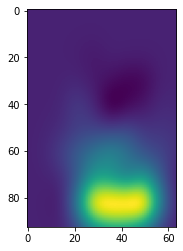

In [96]:
plt.imshow(field[15, :, :, 2])

In [98]:
# Write the meshes

movingMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Source model(rigidly registered)_1.vtk'
fixedMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Target Pointcloud_1.vtk'

movingMesh = itk.meshread(movingMeshPath)
for i in range(0, movingMesh.GetNumberOfPoints()):
    movingMesh.SetPoint(i, final_transform.TransformPoint(movingMesh.GetPoint(i)))

w1 = itk.MeshFileWriter[type(movingMesh)].New()
w1.SetFileName('movingMesh_itk1.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(movingMesh)
w1.Update()


In [ ]:
movingMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Source Pointcloud (rigidly registered)_1.vtk'
fixedMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Target Pointcloud_1.vtk'

movingMesh = readvtk(movingMeshPath)
                         
for n in range(0, numberOfPoints):
    movingPSNew.SetPoint(n, final_transform.TransformPoint(movingPS.GetPoint(n)))

In [81]:
movingMesh_itk_np = itk.array_from_vector_container(movingMesh.GetPoints())
print(movingMesh_itk_np.shape)

(2351553, 3)


In [92]:
test1 = readvtk('/home/pranjal.sahu/Documents/SampleApeData1/USNM174722-Cranium.vtk')
test2 = readvtk('movingMesh_itk.vtk')
test3 = readvtk('/home/pranjal.sahu/Documents/SampleApeData1/TPS Warped source model_1.vtk')

itkwidgets.view(geometries=[test1, test2, test3])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [72]:
movingPS_np = itk.array_from_vector_container(movingPS.GetPoints())
fixedPS_np = itk.array_from_vector_container(fixedPS.GetPoints())
movingPSNew_np = itk.array_from_vector_container(movingPSNew.GetPoints())

itkwidgets.view(point_sets=[movingPS_np, movingPSNew_np, fixedPS_np])

Viewer(geometries=[], gradient_opacity=0.22, point_set_colors=array([[0.8392157 , 0.        , 0.        ],
   …

(55, 94, 64, 3)


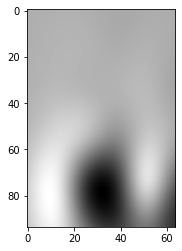

In [18]:
# Visualized the Displacement Field obtained from BSpline Transform

print(field.shape)
import matplotlib.pyplot as plt
plt.imshow(field[15, :, :, 0], cmap='gray')

In [6]:
# Visualize the results after RANSAC ICP

from itkwidgets import view

def readvtk(filename):
    a = vtk.vtkPolyDataReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

def readply(filename):
    a = vtk.vtkPLYReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

#m1 = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174701-Cranium_merged_1.vtk')
m1 = readvtk('fixedMesh.vtk')
#m2 = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.vtk')
m2 = readvtk('ransacICPResult2_b.vtk')
#m3 = readvtk('ransacICPResult2_b_check.vtk')
m3 = readvtk('ransacICPResult2_c_check.vtk')


view(geometries=[m1, m2, m3])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [ ]:
# TSD registration

imageDiagonal   = 50
stretchWeight   = 0.0001
bendWeight      = 0.0001
geometricWeight = 0.0001
maxStep         = 1
numOfIterations = 20
learningRate    = 1

movingMesh = itk.meshread('movingMesh.vtk', itk.D)
fixedMesh  = itk.meshread('fixedMesh.vtk', itk.D)

print('Number of Points are')
print(movingMesh.GetNumberOfPoints())
print(fixedMesh.GetNumberOfPoints())

fixedMesh.BuildCellLinks()
movingMesh.BuildCellLinks()

PixelType = itk.D
Dimension = 3

MeshType        = itk.Mesh[itk.D, Dimension]
FixedImageType  = itk.Image[PixelType, Dimension]

# For getting the Bounding Box
ElementIdentifierType = itk.UL
CoordType = itk.F
Dimension = 3

VecContType = itk.VectorContainer[
    ElementIdentifierType, itk.Point[CoordType, Dimension]
]
bounding_box = itk.BoundingBox[ElementIdentifierType, Dimension, CoordType, VecContType].New()
bounding_box.SetPoints(movingMesh.GetPoints())
bounding_box.ComputeBoundingBox()

minBounds = np.array(bounding_box.GetMinimum())
maxBounds = np.array(bounding_box.GetMaximum())


spacing = np.sqrt(bounding_box.GetDiagonalLength2()) / imageDiagonal
diff = maxBounds - minBounds

print('Spacing ', spacing)
print('minBounds ', minBounds)
print('maxBounds ', maxBounds)

fixedImageSize    = [0]*3
fixedImageSize[0] = math.ceil( 1.2 * diff[0] / spacing )
fixedImageSize[1] = math.ceil( 1.2 * diff[1] / spacing )
fixedImageSize[2] = math.ceil( 1.2 * diff[2] / spacing )

fixedImageOrigin    = [0]*3
fixedImageOrigin[0] = minBounds[0] - 0.1 * diff[0]
fixedImageOrigin[1] = minBounds[1] - 0.1 * diff[1]
fixedImageOrigin[2] = minBounds[2] - 0.1 * diff[2]

fixedImageSpacing   = np.ones(3)*spacing
fixedImageDirection = np.identity(3)


fixedImage = FixedImageType.New()
fixedImage.SetRegions(fixedImageSize)
fixedImage.SetOrigin( fixedImageOrigin )
fixedImage.SetDirection( fixedImageDirection )
fixedImage.SetSpacing( fixedImageSpacing )
fixedImage.Allocate()


# Create BSpline Transformation object and initialize the parameters
SplineOrder = 3
TransformType  = itk.BSplineTransform[itk.D, Dimension, SplineOrder]
InitializerType = itk.BSplineTransformInitializer[TransformType, FixedImageType]

transform = TransformType.New()

# Higher the grid dimensio, slower the computation but higher will be the accuracy
numberOfGridNodesInOneDimension = 8
transformInitializer = InitializerType.New()
transformInitializer.SetTransform(transform)
transformInitializer.SetImage(fixedImage)
transformInitializer.SetTransformDomainMeshSize(numberOfGridNodesInOneDimension - SplineOrder)
transformInitializer.InitializeTransform()



MetricType = itk.ThinShellDemonsMetricv4.MD3
metric = MetricType.New()
metric.SetStretchWeight(stretchWeight)
metric.SetBendWeight(bendWeight)
metric.SetGeometricFeatureWeight(geometricWeight)
metric.UseConfidenceWeightingOn()
metric.UseMaximalDistanceConfidenceSigmaOff()
metric.UpdateFeatureMatchingAtEachIterationOn()
metric.SetMovingTransform(transform)
# Reversed due to using points instead of an image
# to keep semantics the same as in itkThinShellDemonsTest.cxx
# For the ThinShellDemonsMetricv4 the fixed mesh is regularized
metric.SetFixedPointSet(movingMesh)
metric.SetMovingPointSet(fixedMesh)
metric.SetVirtualDomainFromImage(fixedImage)
metric.Initialize()

print('TSD Metric Created')


optimizer = itk.RegularStepGradientDescentOptimizerv4.D.New()
optimizer.SetNumberOfIterations( numOfIterations )
optimizer.SetMaximumStepSizeInPhysicalUnits( maxStep )
optimizer.SetLearningRate(learningRate)
optimizer.SetMinimumConvergenceValue( 0.0 )
optimizer.SetConvergenceWindowSize( numOfIterations )

def iteration_update():
    metric_value = optimizer.GetValue()
    current_parameters = optimizer.GetCurrentPosition()
    print(f"Metric: {metric_value:.8g}")

iteration_command = itk.PyCommand.New()
iteration_command.SetCommandCallable(iteration_update)
optimizer.AddObserver(itk.IterationEvent(), iteration_command)


print('Number of Transform Parameters ', transform.GetNumberOfParameters())

AffineRegistrationType = itk.ImageRegistrationMethodv4.REGv4D3D3TD3D3MD3.New()
registration = AffineRegistrationType.New()
registration.SetNumberOfLevels(1)
registration.SetObjectName("registration")
registration.SetFixedPointSet(movingMesh)
registration.SetMovingPointSet(fixedMesh)
registration.SetInitialTransform(transform)
registration.SetMetric(metric)
registration.SetOptimizer(optimizer)
registration.InPlaceOn()

print('Registration Object created')
print('Initial Value of Metric ', metric.GetValue())

try:
    registration.Update()
except e:
    print('Error is ', e)

print('Final Value of TSD Metric ', metric.GetValue())


# Get the Displacement field from the BSpline Transform
finalTransform = registration.GetModifiableTransform()
convertFilter = itk.TransformToDisplacementFieldFilter.IVF33D.New()
convertFilter.SetTransform(finalTransform)
convertFilter.UseReferenceImageOn()
convertFilter.SetReferenceImage(fixedImage)
convertFilter.Update()
field = convertFilter.GetOutput()
field = np.array(field)
np.save('displacement_field.npy', field)

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedMesh)
e_metric.SetMovingPointSet(movingMesh)
print('Euclidean Metric Before TSD Deformable Registration ', e_metric.GetValue())

numberOfPoints = movingMesh.GetNumberOfPoints()
for n in range(0, numberOfPoints):
    movingMesh.SetPoint(n, finalTransform.TransformPoint(movingMesh.GetPoint(n)))

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedMesh)
e_metric.SetMovingPointSet(movingMesh)
print('Euclidean Metric After TSD Deformable Registration ', e_metric.GetValue())

itk.meshwrite(movingMesh, 'result_bspline.vtk')

In [ ]:
# Visualize the fixed mesh, moving mesh and the registered mesh

a = vtk.vtkPolyDataReader()
a.SetFileName('ransacICPResult2.vtk')
a.Update()
m1 = a.GetOutput()

a = vtk.vtkPolyDataReader()
a.SetFileName('result_bspline.vtk')
a.Update()
m2 = a.GetOutput()

a = vtk.vtkPolyDataReader()
a.SetFileName('fixedMesh.vtk')
a.Update()
m3 = a.GetOutput()

itkwidgets.view(geometries=[m1, m2, m3])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [ ]:
#finalTransform = registration.GetModifiableTransform()
convertFilter = itk.TransformToDisplacementFieldFilter.IVF33D.New()
convertFilter.SetTransform(final_transform)
convertFilter.UseReferenceImageOn()
convertFilter.SetReferenceImage(fixedImage)
convertFilter.Update()
field = convertFilter.GetOutput()
field = np.array(field)
np.save('displacement_field.npy', field)

(24, 48, 29, 3)


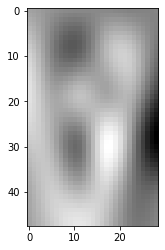

In [36]:
# Visualized the Displacement Field obtained from BSpline Transform

print(field.shape)
import matplotlib.pyplot as plt
plt.imshow(field[15, :, :, 0], cmap='gray')

In [172]:
# Checking Point to Plane ICP

import open3d as o3d
from open3d import geometry
from open3d import utility

source = geometry.PointCloud()
source.points = utility.Vector3dVector(itk_transformed_points)

target = geometry.PointCloud()
target.points = utility.Vector3dVector(fixedMeshPoints)

radius_normal = 5

target.estimate_normals(
    geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

trans_init = np.identity(4)
threshold = 10

convergence = o3d.pipelines.registration.TransformationEstimationPointToPlane()

print("Apply point-to-point ICP")
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init, convergence,
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=1000))

print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
#draw_registration_result(source, target, reg_p2p.transformation)

Apply point-to-point ICP
RegistrationResult with fitness=6.731486e-01, inlier_rmse=4.562815e+00, and correspondence_set size of 2527
Access transformation to get result.
Transformation is:
[[  0.95502067   0.13828085  -0.26232407 -12.74522843]
 [ -0.11599785   0.98833485   0.09868494  14.89261294]
 [  0.27291026  -0.06381713   0.9599205   -9.09552887]
 [  0.           0.           0.           1.        ]]


In [173]:
# For getting distance after open 3d icp

sp = np.asarray(source_temp.points)
tp = np.asarray(target_temp.points)

print(sp.shape, tp.shape)

moving_ps = itk.Mesh[itk.D, 3].New()
fixed_ps = itk.Mesh[itk.D, 3].New()

fixed_ps.SetPoints(itk.vector_container_from_array(tp.flatten().astype('float32')))
moving_ps.SetPoints(itk.vector_container_from_array(sp.flatten().astype('float32')))

MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
metric = MetricType.New()
metric.SetMovingPointSet(moving_ps)
metric.SetFixedPointSet(fixed_ps)
metric.Initialize()

print(metric.GetValue())

(3754, 3) (8002, 3)
8.35966483323909


In [135]:
print('final_mesh points ', final_mesh.shape[0])
print('fixedMeshPoints points ', fixedMeshPoints.shape[0])
print('itk_transformed_points points ', itk_transformed_points.shape[0])

final_mesh points  3754
fixedMeshPoints points  8002
itk_transformed_points points  3754


In [136]:
# For getting distance after ITK ICP

moving_ps = itk.Mesh[itk.D, 3].New()
fixed_ps = itk.Mesh[itk.D, 3].New()

fixed_ps.SetPoints(itk.vector_container_from_array(fixedMeshPoints.flatten().astype('float32')))
#moving_ps.SetPoints(itk.vector_container_from_array(itk_transformed_points.flatten().astype('float32')))
moving_ps.SetPoints(itk.vector_container_from_array(final_mesh.flatten().astype('float32')))

MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
metric = MetricType.New()
metric.SetMovingPointSet(fixed_ps)
metric.SetFixedPointSet(moving_ps)
metric.Initialize()

print(metric.GetValue())

9.055943657675051


In [130]:
print(fixed_ps.GetNumberOfPoints(), moving_ps.GetNumberOfPoints())

8002 3754


In [105]:
itkwidgets.view(point_sets=[sp, tp])

Viewer(geometries=[], gradient_opacity=0.22, point_set_colors=array([[0.8392157 , 0.        , 0.        ],
   …

In [102]:
source_temp = copy.deepcopy(source)
target_temp = copy.deepcopy(target)
source_temp.transform(reg_p2p.transformation)

PointCloud with 3754 points.

In [63]:
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

In [58]:
trans_init = np.identity(4)
print(trans_init)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [ ]:
movingMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Source Pointcloud (rigidly registered)_1.vtk'
fixedMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Target Pointcloud_1.vtk'

movingMesh = readvtk(movingMeshPath)
fixedMesh  = readvtk(fixedMeshPath)

#itkwidgets.view(geometries=[fixedMesh, movingMesh])

print(movingMesh.GetNumberOfPoints())